In [1]:
import pandas as pd
import numpy as np
import texthero as hero
import nltk
import nltk.data
import re
from nltk.corpus import stopwords
%matplotlib inline
from keras.utils import np_utils
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import metrics
import googletrans
from googletrans import Translator

df = pd.read_csv('df.csv')

#Nettoyage de la colonne designation

from texthero import preprocessing
custom_pipeline = [preprocessing.fillna
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_html_tags
                   , preprocessing.remove_urls
                   , preprocessing.lowercase
                   , preprocessing.tokenize]

df['clean_title'] = hero.clean(df['designation'], pipeline = custom_pipeline)



from nltk.corpus import stopwords
stops = set(stopwords.words("french"))                  
#
def remove_stops(df):
    my_list = df['clean_title']
    meaningful_words = [w for w in my_list if not w in stops]
    return meaningful_words

df['clean_title'] = df.apply(remove_stops, axis=1)

df.head()


,productid,designation,description,imageid,prdtypecode,target,clean_title
0,3804725264,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,1263597046,10,0,"[olivia, personalisiertes, notizbuch, seiten, ..."
1,436067568,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,1008141237,2280,1,"[journal, arts, ndeg, art, marche, salon, art,..."
2,201115110,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,938777978,50,2,"[grand, stylet, ergonomique, bleu, gamepad, ni..."
3,50418756,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,457047496,1280,3,"[peluche, donald, europe, disneyland, marionne..."
4,278535884,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,1077757786,2705,4,"[guerre, tuques]"


In [42]:
#translator = Translator()
#df['trad'] = df['clean_title'].apply(translator.translate, dest='fr').apply(getattr, args=('text',))

/Users/lucasgandy/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

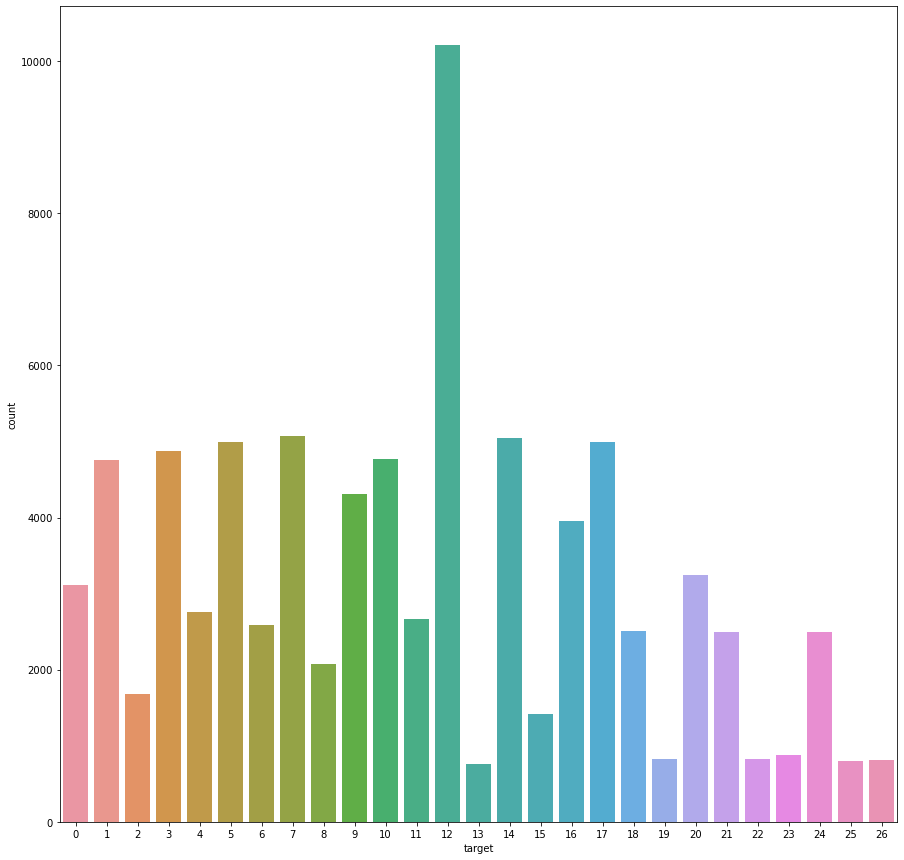

In [2]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.countplot(df['target'])

In [2]:
import tensorflow as tf
def macro_soft_f1(y, y_hat):

    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0) # on multiplie la proba prédite d'un classe (y_hat) par son label=> Uniquement les proba des vrai positifs seront non nuls
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16) #  calcul du F1 score , 1e-16 pour ne pas diviser par 0
    cost = 1 - soft_f1 # comme on cherche a maximiser F1_score , et qu'il nous faut une fonction coût à minimiser duce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # on fait la moyenne pour tous les labels du batch
    return macro_cost

def macro_f1(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [4]:
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras import layers
#from keras.wrappers.scikit_learn import KerasClassifier
#from sklearn.model_selection import RandomizedSearchCV
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization, RNN,Conv2D
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU,Flatten,Reshape,MaxPooling2D
from tensorflow.keras import regularizers

embedding_dim = 100
maxlen = 10

sentences = df['clean_title'].values
y = pd.get_dummies(df['target']).values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.20, random_state=0)


tokenizer = Tokenizer( filters='0123456789!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)



vocab_size = len(tokenizer.word_index) + 1


X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)



model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(27, activation='softmax'))

         
model.compile(loss=macro_soft_f1, optimizer='adam', metrics=['accuracy',macro_f1])
#model.summary()

history = model.fit(X_train, y_train,
                   epochs= 10,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size= 64)

loss, accuracy, f1 = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy, f1 = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))




Epoch 1/10
1062/1062 [==============================] - 84s 78ms/step - loss: 0.8112 - accuracy: 0.3731 - macro_f1: 0.1805 - val_loss: 0.5196 - val_accuracy: 0.6862 - val_macro_f1: 0.4987
Epoch 2/10
1062/1062 [==============================] - 79s 75ms/step - loss: 0.4760 - accuracy: 0.7378 - macro_f1: 0.5501 - val_loss: 0.4681 - val_accuracy: 0.7321 - val_macro_f1: 0.5447
Epoch 3/10
1062/1062 [==============================] - 85s 80ms/step - loss: 0.4001 - accuracy: 0.8070 - macro_f1: 0.6147 - val_loss: 0.4523 - val_accuracy: 0.7476 - val_macro_f1: 0.5588
Epoch 4/10
1062/1062 [==============================] - 93s 87ms/step - loss: 0.3635 - accuracy: 0.8451 - macro_f1: 0.6463 - val_loss: 0.4450 - val_accuracy: 0.7513 - val_macro_f1: 0.5639
Epoch 5/10
1062/1062 [==============================] - 92s 86ms/step - loss: 0.3390 - accuracy: 0.8618 - macro_f1: 0.6681 - val_loss: 0.4389 - val_accuracy: 0.7567 - val_macro_f1: 0.5673
Epoch 6/10
1062/1062 [==============================] - 86s 

              precision    recall  f1-score   support

           0       0.52      0.30      0.38       620
           1       0.74      0.77      0.76       951
           2       0.73      0.73      0.73       328
           3       0.63      0.71      0.67       943
           4       0.45      0.70      0.54       567
           5       0.91      0.89      0.90      1009
           6       0.72      0.71      0.72       501
           7       0.84      0.81      0.82       995
           8       0.47      0.40      0.43       390
           9       0.86      0.89      0.88       848
          10       0.74      0.67      0.71       943
          11       0.72      0.73      0.73       553
          12       0.93      0.95      0.94      1990
          13       0.23      0.57      0.33       155
          14       0.98      0.79      0.88      1004
          15       0.64      0.73      0.68       309
          16       0.91      0.90      0.91       788
          17       0.71    

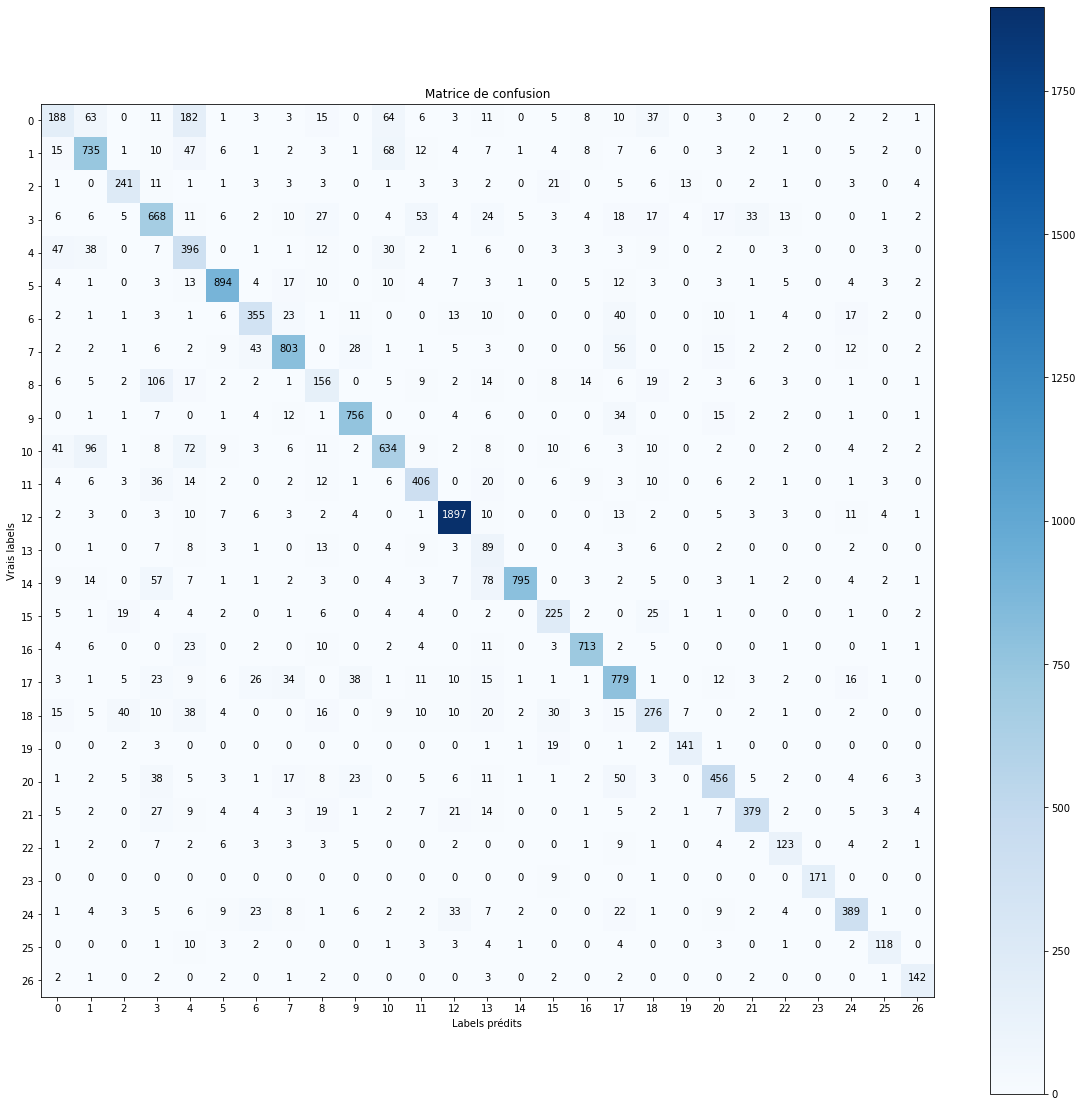

In [5]:
import itertools
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
test_pred_class = y_pred.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)
print(classification_report(y_test_class,test_pred_class))
cnf_matrix = metrics.confusion_matrix(y_test_class,test_pred_class)

classes = range(0,27)


plt.figure(figsize=(20,20))
plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      if(cnf_matrix[i,j] >20 and i!=j):
          print("La classe {0} a souvent été prise pour la classe {1}".format(i,j))

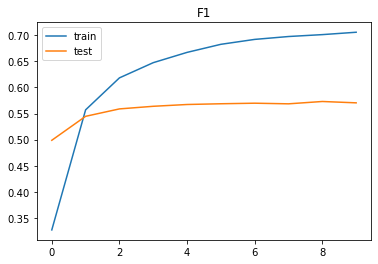

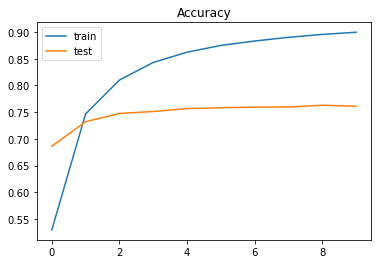

In [7]:
plt.title('F1')
plt.plot(history.history['macro_f1'], label='train')
plt.plot(history.history['val_macro_f1'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [26]:
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras import layers
#from keras.wrappers.scikit_learn import KerasClassifier
#from sklearn.model_selection import RandomizedSearchCV
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization, RNN,Conv2D
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU,Flatten,Reshape,MaxPooling2D
from tensorflow.keras import regularizers

embedding_dim = 100
maxlen = 10


model2 = Sequential()
model2.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model2.add(layers.SpatialDropout1D(0.2))
model2.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model2.add(layers.Dense(27, activation='softmax'))
         
model2.compile(loss=macro_soft_f1, optimizer='adam', metrics=['accuracy',macro_f1])
#model.summary()

history2 = model2.fit(X_train, y_train,
                   epochs= 20,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size= 500)

loss, accuracy, f1 = model2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy, f1 = model2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))





Epoch 1/20
136/136 [==============================] - 29s 188ms/step - loss: 0.9256 - accuracy: 0.1940 - macro_f1: 0.0366 - val_loss: 0.6395 - val_accuracy: 0.5308 - val_macro_f1: 0.3681
Epoch 2/20
136/136 [==============================] - 25s 185ms/step - loss: 0.5654 - accuracy: 0.5782 - macro_f1: 0.4600 - val_loss: 0.4371 - val_accuracy: 0.6456 - val_macro_f1: 0.5826
Epoch 3/20
136/136 [==============================] - 25s 184ms/step - loss: 0.3877 - accuracy: 0.6898 - macro_f1: 0.6360 - val_loss: 0.3866 - val_accuracy: 0.6725 - val_macro_f1: 0.6268
Epoch 4/20
136/136 [==============================] - 25s 184ms/step - loss: 0.3139 - accuracy: 0.7439 - macro_f1: 0.7028 - val_loss: 0.3612 - val_accuracy: 0.6869 - val_macro_f1: 0.6492
Epoch 5/20
136/136 [==============================] - 29s 214ms/step - loss: 0.2604 - accuracy: 0.7791 - macro_f1: 0.7529 - val_loss: 0.3423 - val_accuracy: 0.6981 - val_macro_f1: 0.6650
Epoch 6/20
136/136 [==============================] - 30s 220ms/s

              precision    recall  f1-score   support

           0       0.52      0.30      0.38       620
           1       0.74      0.77      0.76       951
           2       0.73      0.73      0.73       328
           3       0.63      0.71      0.67       943
           4       0.45      0.70      0.54       567
           5       0.91      0.89      0.90      1009
           6       0.72      0.71      0.72       501
           7       0.84      0.81      0.82       995
           8       0.47      0.40      0.43       390
           9       0.86      0.89      0.88       848
          10       0.74      0.67      0.71       943
          11       0.72      0.73      0.73       553
          12       0.93      0.95      0.94      1990
          13       0.23      0.57      0.33       155
          14       0.98      0.79      0.88      1004
          15       0.64      0.73      0.68       309
          16       0.91      0.90      0.91       788
          17       0.71    

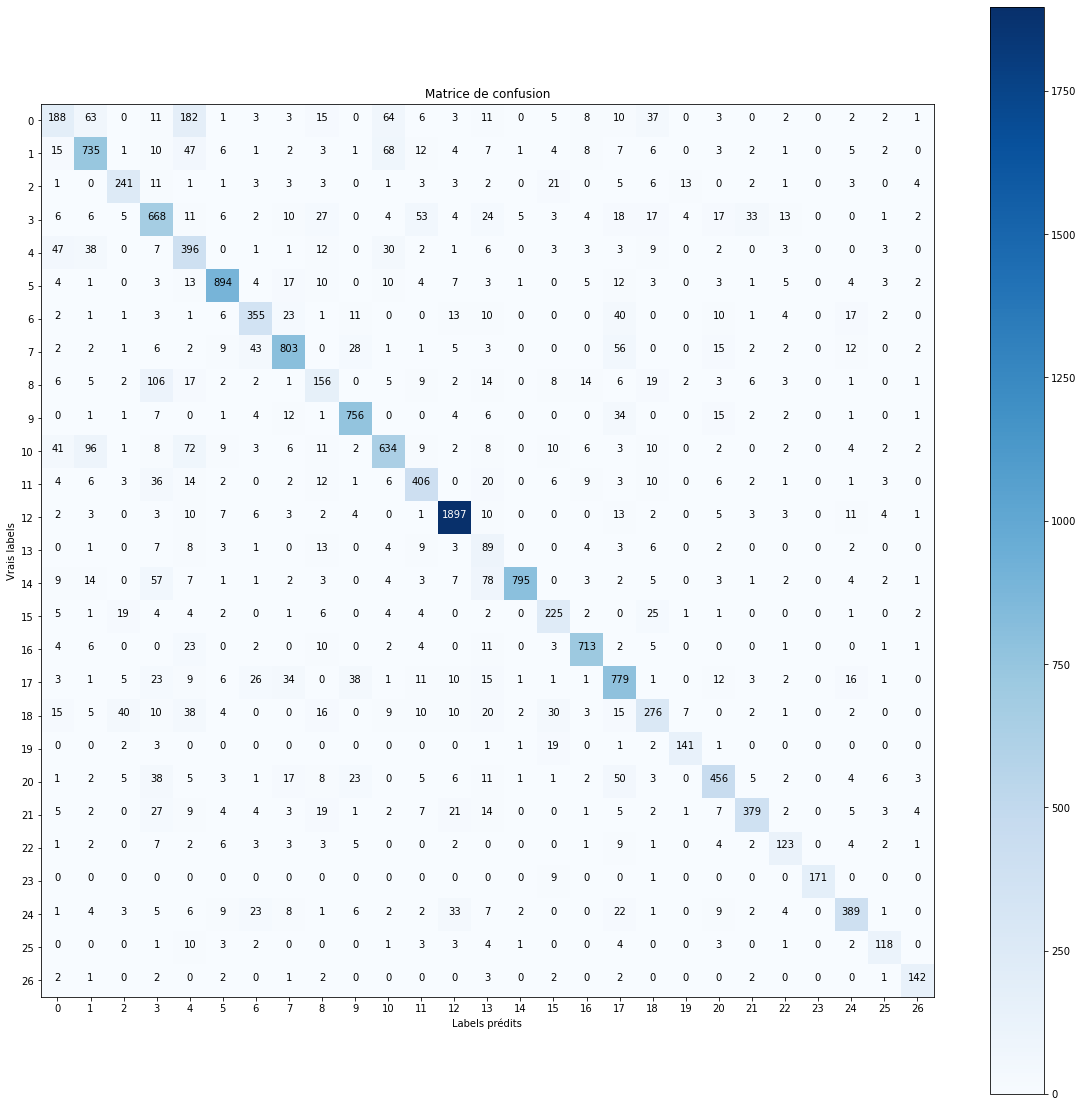

In [27]:
import itertools
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
test_pred_class = y_pred.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)
print(classification_report(y_test_class,test_pred_class))
cnf_matrix = metrics.confusion_matrix(y_test_class,test_pred_class)

classes = range(0,27)


plt.figure(figsize=(20,20))
plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

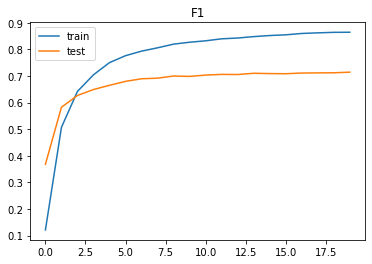

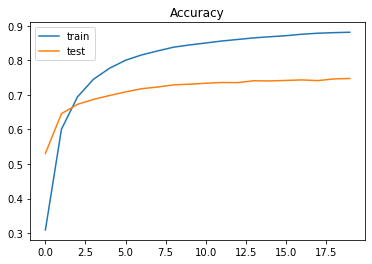

In [28]:
plt.title('F1')
plt.plot(history2.history['macro_f1'], label='train')
plt.plot(history2.history['val_macro_f1'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [29]:
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras import layers
#from keras.wrappers.scikit_learn import KerasClassifier
#from sklearn.model_selection import RandomizedSearchCV
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization, RNN,Conv2D
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU,Flatten,Reshape,MaxPooling2D
from tensorflow.keras import regularizers

embedding_dim = 100
maxlen = 10



model3 = Sequential()
model3.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model3.add(layers.SpatialDropout1D(0.2))
model3.add(layers.GRU(100, dropout=0.2, recurrent_dropout=0.2))
model3.add(layers.Dense(27, activation='softmax'))
       
model3.compile(loss=macro_soft_f1, optimizer='adam', metrics=['accuracy',macro_f1])
#model.summary()

history3 = model3.fit(X_train, y_train,
                   epochs= 20,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size= 500)

loss, accuracy, f1 = model3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy, f1 = model3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))






Epoch 1/20
136/136 [==============================] - 31s 199ms/step - loss: 0.9320 - accuracy: 0.1851 - macro_f1: 0.0315 - val_loss: 0.6877 - val_accuracy: 0.4752 - val_macro_f1: 0.3137
Epoch 2/20
136/136 [==============================] - 25s 185ms/step - loss: 0.6220 - accuracy: 0.5344 - macro_f1: 0.3862 - val_loss: 0.4776 - val_accuracy: 0.6244 - val_macro_f1: 0.5432
Epoch 3/20
136/136 [==============================] - 24s 173ms/step - loss: 0.4356 - accuracy: 0.6683 - macro_f1: 0.5957 - val_loss: 0.4027 - val_accuracy: 0.6705 - val_macro_f1: 0.6193
Epoch 4/20
136/136 [==============================] - 24s 174ms/step - loss: 0.3434 - accuracy: 0.7276 - macro_f1: 0.6833 - val_loss: 0.3762 - val_accuracy: 0.6854 - val_macro_f1: 0.6356
Epoch 5/20
136/136 [==============================] - 24s 175ms/step - loss: 0.2947 - accuracy: 0.7638 - macro_f1: 0.7235 - val_loss: 0.3534 - val_accuracy: 0.7021 - val_macro_f1: 0.6568
Epoch 6/20
136/136 [==============================] - 24s 175ms/s

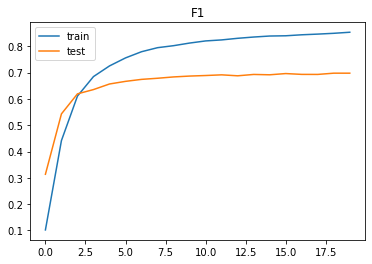

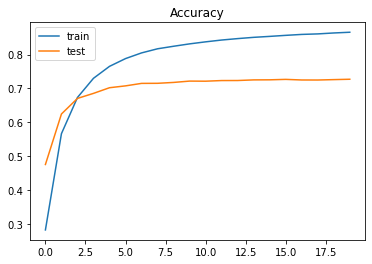

In [30]:
plt.title('F1')
plt.plot(history3.history['macro_f1'], label='train')
plt.plot(history3.history['val_macro_f1'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history3.history['accuracy'], label='train')
plt.plot(history3.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [9]:
from imblearn.under_sampling import RandomUnderSampler
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras import layers
#from keras.wrappers.scikit_learn import KerasClassifier
#from sklearn.model_selection import RandomizedSearchCV
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization, RNN,Conv2D
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU,Flatten,Reshape,MaxPooling2D
from tensorflow.keras import regularizers

embedding_dim = 100
maxlen = 10

#Test du meilleur algo avec Undersampling pour équilibre des classes
sentences = df['clean_title'].values
y = pd.get_dummies(df['target']).values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.20, random_state=0)


tokenizer = Tokenizer( filters='0123456789!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)



vocab_size = len(tokenizer.word_index) + 1


X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

rUs = RandomUnderSampler()
X_train, y_train = rUs.fit_resample(X_train, y_train)

model4 = Sequential()
model4.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model4.add(layers.SpatialDropout1D(0.2))
model4.add(layers.Conv1D(32, 3, activation='relu'))
model4.add(layers.GlobalMaxPooling1D())
model4.add(layers.Dense(27, activation='softmax'))

         
model4.compile(loss=macro_soft_f1, optimizer='adam', metrics=['accuracy',macro_f1])
#model.summary()

history = model4.fit(X_train, y_train,
                   epochs= 10,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size= 64)

loss, accuracy, f1 = model4.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy, f1 = model4.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))





/Users/lucasgandy/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Epoch 1/10
257/257 [==============================] - 22s 83ms/step - loss: 0.9393 - accuracy: 0.1466 - macro_f1: 0.0277 - val_loss: 0.7727 - val_accuracy: 0.4292 - val_macro_f1: 0.2178
Epoch 2/10
257/257 [==============================] - 23s 88ms/step - loss: 0.6507 - accuracy: 0.5263 - macro_f1: 0.3542 - val_loss: 0.6062 - val_accuracy: 0.5825 - val_macro_f1: 0.4244
Epoch 3/10
257/257 [==============================] - 20s 79ms/step - loss: 0.4546 - accuracy: 0.6939 - macro_f1: 0.5969 - val_loss: 0.5518 - val_accuracy: 0.6392 - val_macro_f1: 0.4784
Epoch 4/10
257/257 [==============================] - 20s 77ms/step - loss: 0.3416 - accuracy: 0.7867 - macro_f1: 0.6977 - val_loss: 0.5320 - val_accuracy: 0.6587 - val_macro_f1: 0.4960
Epoch 5/10
257/257 [==============================] - 19s 75ms/step - loss: 0.2932 - accuracy: 0.8231 - macro_f1: 0.7301 - val_loss: 0.5249 - val_accuracy: 0.6630 - val_macro_f1: 0.5001
Epoch 6/10
257/257 [==============================] - 22s 85ms/step - 

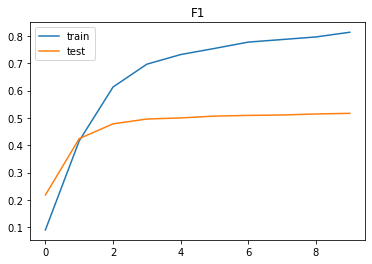

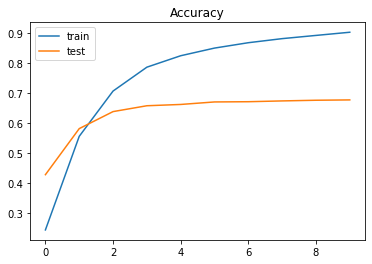

In [11]:
plt.title('F1')
plt.plot(history.history['macro_f1'], label='train')
plt.plot(history.history['val_macro_f1'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();